# **Binary Classification - Ontario / Toronto Covid-19 Cases**

In [30]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot

In [3]:
# Import our input dataset
df = pd.read_csv('../Resources/Ontario.csv')
df.head()

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-03-07,2020-03-09,2020-03-11,2020-03-09,50s,MALE,Travel,Resolved,NaN,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,www.york.ca/wps/portal/yorkhome/health/,44.048023,-79.480239
1,2,2020-03-02,2020-03-09,2020-03-09,2020-03-09,40s,MALE,Travel,Resolved,NaN,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
2,3,2020-03-06,2020-03-10,2020-03-10,2020-03-09,30s,FEMALE,Travel,Resolved,NaN,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,www.york.ca/wps/portal/yorkhome/health/,44.048023,-79.480239
3,4,2020-03-02,2020-03-09,2020-03-12,2020-03-07,40s,MALE,Travel,Resolved,NaN,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912
4,5,2020-03-03,2020-03-10,2020-03-11,2020-03-09,30s,MALE,Travel,Resolved,NaN,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


## **Pre-Processing**

In [6]:
# Show Number of Columns and Rows
df.shape

(36178, 17)

In [7]:
# Show Columns and Their Data Type
df.dtypes

Row_ID                         int64
Accurate_Episode_Date         object
Case_Reported_Date            object
Test_Reported_Date            object
Specimen_Date                 object
Age_Group                     object
Client_Gender                 object
Case_AcquisitionInfo          object
Outcome1                      object
Outbreak_Related              object
Reporting_PHU                 object
Reporting_PHU_Address         object
Reporting_PHU_City            object
Reporting_PHU_Postal_Code     object
Reporting_PHU_Website         object
Reporting_PHU_Latitude       float64
Reporting_PHU_Longitude      float64
dtype: object

In [8]:
# Creating DataFrame with Outcome & Dependent Variables Required for ML Models
df2 = df[['Outcome1','Age_Group','Client_Gender','Reporting_PHU']]
df2.head()

,Outcome1,Age_Group,Client_Gender,Reporting_PHU
0,Resolved,50s,MALE,York Region Public Health Services
1,Resolved,40s,MALE,Toronto Public Health
2,Resolved,30s,FEMALE,York Region Public Health Services
3,Resolved,40s,MALE,Ottawa Public Health
4,Resolved,30s,MALE,Toronto Public Health


In [9]:
# Inspecting for Null Values
for column in df2.columns:
    print(f"Column {column} has {df2[column].isnull().sum()} null values")

Column Outcome1 has 0 null values
Column Age_Group has 0 null values
Column Client_Gender has 0 null values
Column Reporting_PHU has 0 null values


In [10]:
# Inspecting for Deplicated Rows (Which is totally understandable as DataFrame contains individual cases from the Region)
print(f"Duplicate entries: {df2.duplicated().sum()}")

Duplicate entries: 35132


In [11]:
# Create Categorical Variable List
df2_cat = df2.dtypes[df2.dtypes == "object"].index.tolist()
df2_cat

['Outcome1', 'Age_Group', 'Client_Gender', 'Reporting_PHU']

In [12]:
# Unique numbers
df2[df2_cat].nunique()

Outcome1          3
Age_Group        10
Client_Gender     5
Reporting_PHU    34
dtype: int64

#### Bucketing and/or Binning
Collapse all of the infrequent and rare categorical values into a single “other” category.

In [13]:
# Checking for the Covid-19 Cases by Health Region
Reporting_PHU_counts = df2.Reporting_PHU.value_counts()
Reporting_PHU_counts

Toronto Public Health                                       13511
Peel Public Health                                           6027
York Region Public Health Services                           3082
Ottawa Public Health                                         2123
Durham Region Health Department                              1724
Windsor-Essex County Health Unit                             1675
Region of Waterloo, Public Health                            1313
Hamilton Public Health Services                               847
Halton Region Health Department                               781
Niagara Region Public Health Department                       763
Middlesex-London Health Unit                                  631
Simcoe Muskoka District Health Unit                           607
Wellington-Dufferin-Guelph Public Health                      493
Haldimand-Norfolk Health Unit                                 431
Leeds, Grenville and Lanark District Health Unit              354
Lambton Pu

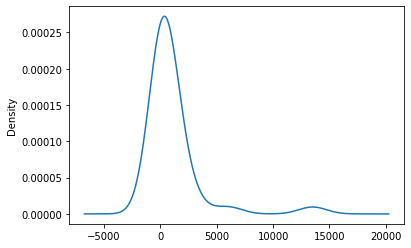

In [14]:
# Visualize the value counts
Reporting_PHU_counts.plot.density()

In [16]:
# Replacing Health Region with less than 400 cases by "Other"
replace_Reporting_PHU = list(Reporting_PHU_counts[Reporting_PHU_counts < 400].index)

for i in replace_Reporting_PHU:
    df2.Reporting_PHU  = df2.Reporting_PHU.replace(i,"Other")

df2.Reporting_PHU .value_counts()

Toronto Public Health                       13511
Peel Public Health                           6027
York Region Public Health Services           3082
Other                                        2170
Ottawa Public Health                         2123
Durham Region Health Department              1724
Windsor-Essex County Health Unit             1675
Region of Waterloo, Public Health            1313
Hamilton Public Health Services               847
Halton Region Health Department               781
Niagara Region Public Health Department       763
Middlesex-London Health Unit                  631
Simcoe Muskoka District Health Unit           607
Wellington-Dufferin-Guelph Public Health      493
Haldimand-Norfolk Health Unit                 431
Name: Reporting_PHU, dtype: int64

#### Encoding

In [17]:
# Create the OneHotEncoder Instance
enc = OneHotEncoder(sparse=False)

# Fit the Encoder and Produce Encoded DataFrame
encoded_df2 = pd.DataFrame(enc.fit_transform(df2))

# Rename Encoded Columns
encoded_df2.columns = enc.get_feature_names(df2_cat)
encoded_df2.head()

,Outcome1_Fatal,Outcome1_Not Resolved,Outcome1_Resolved,Age_Group_20s,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60s,Age_Group_70s,Age_Group_80s,...,Reporting_PHU_Niagara Region Public Health Department,Reporting_PHU_Other,Reporting_PHU_Ottawa Public Health,Reporting_PHU_Peel Public Health,"Reporting_PHU_Region of Waterloo, Public Health",Reporting_PHU_Simcoe Muskoka District Health Unit,Reporting_PHU_Toronto Public Health,Reporting_PHU_Wellington-Dufferin-Guelph Public Health,Reporting_PHU_Windsor-Essex County Health Unit,Reporting_PHU_York Region Public Health Services
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
# Remove the Ongoing Cases with Unknown Outcome
encoded_df2 = encoded_df2[encoded_df2['Outcome1_Not Resolved'] != 1]

In [19]:
# Drop Redundant Outcome
encoded_df2 = encoded_df2.drop(columns=['Outcome1_Not Resolved','Outcome1_Fatal'],axis=1)

# We can probably drop "Client_Gender_UNKNOWN" as well.

In [20]:
encoded_df2.head()

,Outcome1_Resolved,Age_Group_20s,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60s,Age_Group_70s,Age_Group_80s,Age_Group_90s,Age_Group_<20,...,Reporting_PHU_Niagara Region Public Health Department,Reporting_PHU_Other,Reporting_PHU_Ottawa Public Health,Reporting_PHU_Peel Public Health,"Reporting_PHU_Region of Waterloo, Public Health",Reporting_PHU_Simcoe Muskoka District Health Unit,Reporting_PHU_Toronto Public Health,Reporting_PHU_Wellington-Dufferin-Guelph Public Health,Reporting_PHU_Windsor-Essex County Health Unit,Reporting_PHU_York Region Public Health Services
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Split our training and testing data

In [21]:
# Split our preprocessed data into our features and target arrays
y = encoded_df2["Outcome1_Resolved"].values
X = encoded_df2.drop(["Outcome1_Resolved"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

## **Machine Learning Model**

In [22]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 248       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=10) #epochs (run through the data)

Epoch 1/10
25878/25878 [==============================] - 1s 38us/sample - loss: 0.4110 - acc: 0.8738
Epoch 2/10
25878/25878 [==============================] - 1s 35us/sample - loss: 0.1912 - acc: 0.9214
Epoch 3/10
25878/25878 [==============================] - 1s 39us/sample - loss: 0.1852 - acc: 0.9214
Epoch 4/10
25878/25878 [==============================] - 1s 38us/sample - loss: 0.1843 - acc: 0.9214
Epoch 5/10
25878/25878 [==============================] - 1s 35us/sample - loss: 0.1839 - acc: 0.9214
Epoch 6/10
25878/25878 [==============================] - 1s 35us/sample - loss: 0.1838 - acc: 0.9214
Epoch 7/10
25878/25878 [==============================] - 1s 34us/sample - loss: 0.1837 - acc: 0.9214
Epoch 8/10
25878/25878 [==============================] - 1s 40us/sample - loss: 0.1837 - acc: 0.9214
Epoch 9/10
25878/25878 [==============================] - 1s 39us/sample - loss: 0.1835 - acc: 0.9215
Epoch 10/10
25878/25878 [==============================] - 1s 38us/sample - loss: 

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8627/8627 - 0s - loss: 0.1877 - acc: 0.9227
Loss: 0.18765885540849572, Accuracy: 0.9226846098899841


## **Other - Visualization of PHU Hotspots in Ontario, Canada**

In [34]:
# Creating DataFrame for Visualization
data_df = df \
.groupby(["Reporting_PHU", "Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases"})

data_df["OnsetWithin"] = "current day"

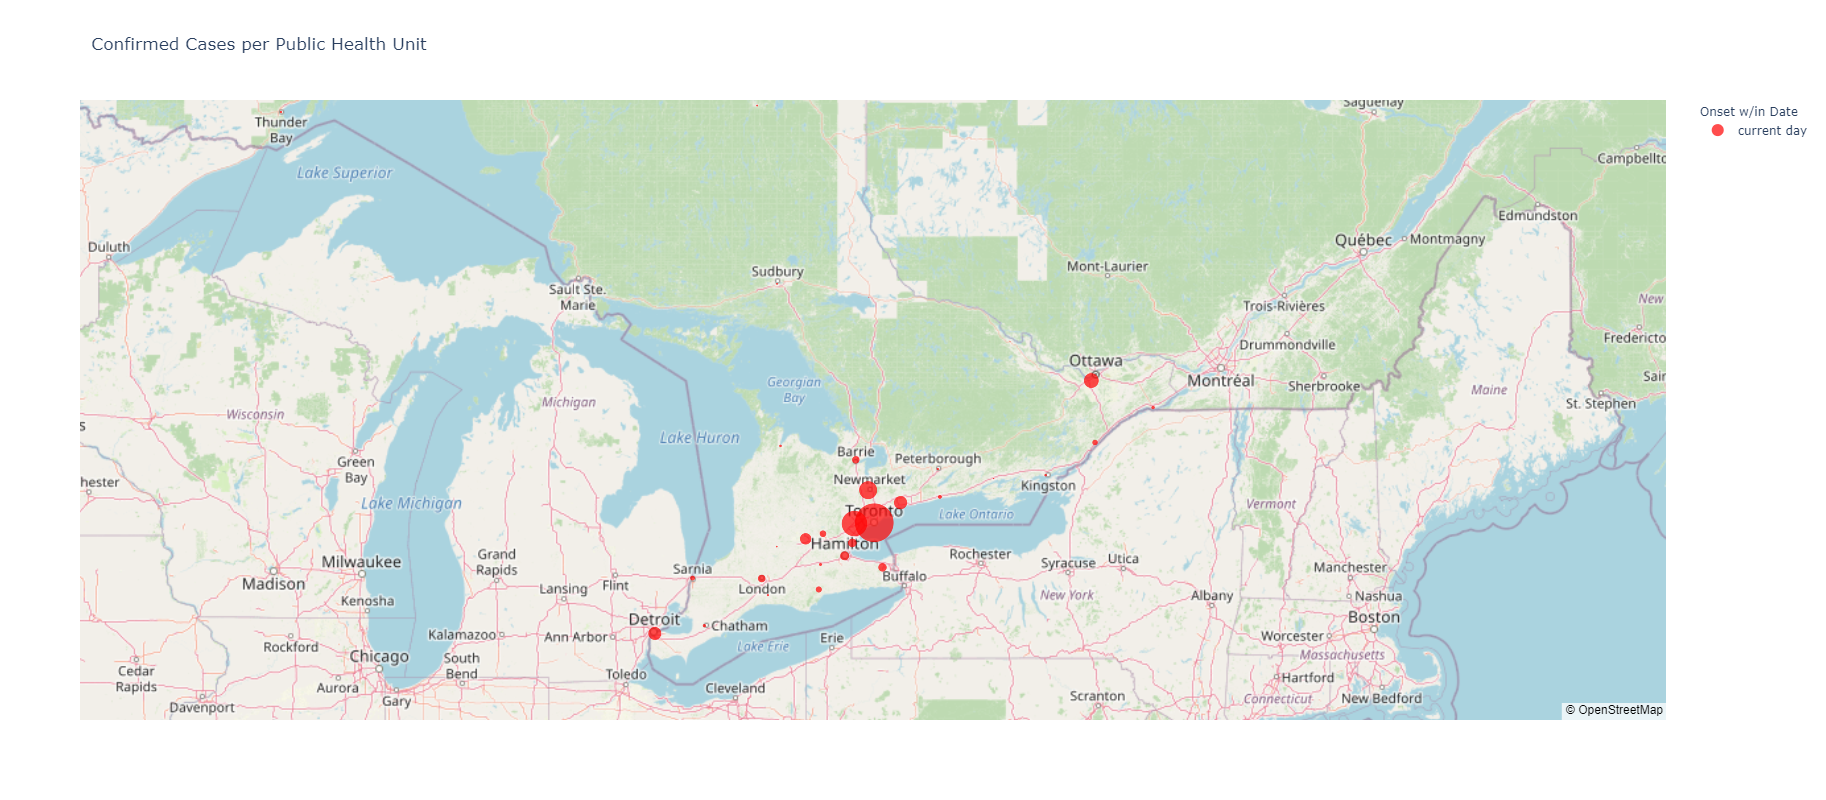

'temp-plot.html'

In [35]:
# Plotting the Cases by Health Region
fig = px.scatter_mapbox(data_df, lat="Reporting_PHU_Latitude", lon="Reporting_PHU_Longitude",  
            color="OnsetWithin", 
            color_discrete_sequence=["red", "darkblue", "yellow", "white"], 
            size="Cases", hover_name="Reporting_PHU", 
            size_max=28, zoom=5.4, 
            center=dict(lat=45,lon=-79.4), 
            height=800, 
            labels={"OnsetWithin" : "Onset w/in Date"},
            title=" Confirmed Cases per Public Health Unit" )
fig.update_layout(mapbox_style="open-street-map")
fig.show()
plot(fig, auto_open=False)